## Assignment 2: T-SNE Visualization of Amazon Reviews with polarity based color coding

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


In [15]:

import sqlite3
import nltk
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.decomposition import TruncatedSVD

In [127]:
con=sqlite3.connect('database.sqlite')

filtered_data=pd.read_sql_query('select *from reviews where score !=3',con)
filtered_data.shape

(525814, 10)

Found some reviews about books also with productID:"0006641040" 


In [128]:
book_data=pd.read_sql_query('select *from reviews where score !=3 and ProductId =0006641040',con)
book_data.head(8)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,150493,0006641040,AMX0PJKV4PPNJ,"E. R. Bird ""Ramseelbird""",71,72,4,1096416000,Read it once. Read it twice. Reading Chicken S...,"These days, when a person says, ""chicken soup""..."
1,150494,0006641040,AYZ0PR5QZROD1,Mother of 3 girls,3,3,5,1173312000,Family favorite,All of my children love this book. My first g...
2,150496,0006641040,A3KKR87BJ0C595,"Gretchen Goodfellow ""Lover of children's lit""",3,3,5,1111363200,"You'll use it once, you'll use it twice",One of my earliest memories is of this book. ...
3,150497,0006641040,A1HKYQOFC8ZZCH,"Maria Apolloni ""lanarossa""",2,2,1,1334707200,"The story is great, the softcover book is disa...",I give five stars to the Maurice Sendak story....
4,150498,0006641040,A3SJWISOCP31TR,R. J. Wells,2,2,5,1176336000,A Gem of a Book,This is a wonderful little book. I loved it 40...
5,150499,0006641040,A3E7R866M94L0C,"L. Barker ""simienwolf""",2,2,5,1065830400,Can't explain why,This book has been a favorite of mine since I ...
6,150500,0006641040,A1IJKK6Q1GTEAY,A Customer,2,2,5,1009324800,It Was a favorite!,This was a favorite book of mine when I was a ...
7,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...


In [129]:
#removing the book review
filtered_data=filtered_data[filtered_data.ProductId != '0006641040']
filtered_data.shape

(525780, 10)

In [130]:
#removing duplicates
sorted_data=filtered_data.sort_values('ProductId',axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')
final_data=sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'},keep='first',inplace=False)
final_data.shape

(364139, 10)

In [131]:
#Helpulness Numerator less than are equal to helpfulnessDemoninator
final=final_data[final_data.HelpfulnessNumerator<=final_data.HelpfulnessDenominator]
final.shape

(364137, 10)

In [132]:
#Scores distribution
final['Score'].value_counts()

5    250945
4     56084
1     36305
2     20803
Name: Score, dtype: int64

In [133]:
def partition(x):
    if x<3:
        return 'Negative'
    return 'Positive'
actualScore=final['Score']
PositiveNegative=actualScore.map(partition)
final['Score']=PositiveNegative

final.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
476617,515426,141278509X,AB1A5EGHHVA9M,CHelmic,1,1,Positive,1332547200,The best drink mix,This product by Archer Farms is the best drink...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,Positive,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...


## Text Preprocessing
Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [134]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

5
Freeze dried liver has a hypnotic effect on dogs.  They LOVE it and will do just about anything for it, so it is a great treat to use for training.  (Powdered freeze dried liver is even added to many dog medicines nowadays-- heartworm and arthritis tablets, etc.-- because it causes the dog to scarf the medicine down like a treat.)<br /><br />Freeze dried liver has a dry, hard, yet powdery/easy to chew consistency.  It comes chopped/cubed.  It is extremely lightweight due to the fact there is so little moisture in the product (thus the low weights on product labels).<br /><br />Even though your dog will love liver treats, you shouldn't overfeed it.  The manufacturer recommends 1-2 cubes daily for small dogs, 2-3 cubes for medium dogs, and 3-4 cubes for large dogs.<br /><br />The largest package sizes of liver treats tend to be far more economical.  I recommend buying the larger tubs, as you will save lots of money, you'll have a handy treat supply around for a longer time, and your do

stop words like not, more, most..etc are import ,becasue review meaning will change by just placing not before good<br>
it is usefull in n_grams to consider these words

In [135]:

stop = set(stopwords.words('english')) #set of stopwords

filter_stop={'not','very',"couldn't","doesn't","shouldn't","wouldn't","didn't",'most','nor','too','no','more'}
final_stop=set(stop)-set(filter_stop)

sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(final_stop)
print('************************************')
print(sno.stem('tasty'))

{'t', 'you', 'until', 'so', 'for', 'my', "you'll", 'is', 'few', 'on', 'such', 'where', 'its', 'doesn', 'his', 'ourselves', "you're", "mustn't", "needn't", 'of', 'off', 'aren', "aren't", 'but', 'couldn', 'your', 'am', 'our', 'are', 'under', 'there', 'down', 'before', 'further', 'y', 'had', 'him', 'he', 'her', "it's", 'be', 'being', 'over', "wasn't", 'isn', 'the', 'yours', 'should', 'll', 'these', 'those', 'haven', 'shouldn', 'were', "that'll", 'and', 'themselves', 'she', 'about', 'they', 'i', 'with', 'above', 'why', 'won', "shan't", 'a', 'o', 'which', 'ma', 'shan', 'into', 'if', 'whom', 'once', 'as', 'himself', "should've", "weren't", 'than', 'how', 'from', 'after', 'ain', 'that', 'in', 'hers', "won't", 'some', 'who', 'm', 'each', 'against', 'both', 'through', "hasn't", 'here', 'because', 'own', 'yourselves', 'didn', "haven't", 'did', 'all', 'mightn', 'itself', 'do', 'other', 'been', 'wasn', "you'd", 'at', 'below', 'what', 's', 'hadn', 'needn', 'myself', 'out', 'does', 'up', 'can', "had

In [136]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in final_stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [137]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
476617,515426,141278509X,AB1A5EGHHVA9M,CHelmic,1,1,Positive,1332547200,The best drink mix,This product by Archer Farms is the best drink...,product archer farm best drink mix ever mix fl...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,Positive,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dog love saw pet store tag attach regard made ...
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,Negative,1192060800,made in china,My dogs loves this chicken but its a product f...,dog love chicken product china wont buy anymor...
284375,308077,2841233731,A3QD68O22M2XHQ,LABRNTH,0,0,Positive,1345852800,Great recipe book for my babycook,This book is easy to read and the ingredients ...,book easi read ingredi avail store unlik recip...
157844,171155,7310172001,A2GD3MQQZC4UT7,"Betsy T. ""sunnymom""",0,0,Positive,1233014400,My Dog's Favorite Treat!,He loves the Liver treats and the Lamb treats....,love liver treat lamb treat theyr not much loo...


Because of the hardware limitaitons taking only 5k points

In [ ]:
# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [2]:
conec=sqlite3.connect("final.sqlite")
positive_reviews=pd.read_sql_query("select * from Reviews where Score='Positive'",conec)
negative_reviews=pd.read_sql_query("select * from Reviews where Score='Negative'",conec)
pos_rev=positive_reviews[0:2000]
neg_rev=negative_reviews[0:2000]
frames=[pos_rev,neg_rev]
final_data=pd.concat(frames,ignore_index=True)
final_data.drop('index',axis=1,inplace=True)
labels=final_data['Score']
final_data.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,515426,141278509X,AB1A5EGHHVA9M,CHelmic,1,1,Positive,1332547200,The best drink mix,This product by Archer Farms is the best drink...,product archer farm best drink mix ever mix fl...


### 1) Applying Bag of words

In [4]:
final_counts=CountVectorizer()
final_vect=final_counts.fit_transform(final_data["CleanedText"].values)
final_vect.shape

(4000, 9568)

In [5]:
final_vector=final_vect.toarray()
type(final_vector)

numpy.ndarray

In [6]:
#Applying TSNE on final_vector with perplexity=20
model=TSNE(n_components=2,perplexity=20,random_state=0)
tnse_data=model.fit_transform(final_vector)
#Appending the label column
tnse_data=np.vstack((tnse_data.T,labels)).T
tnse_data.shape

(4000, 3)

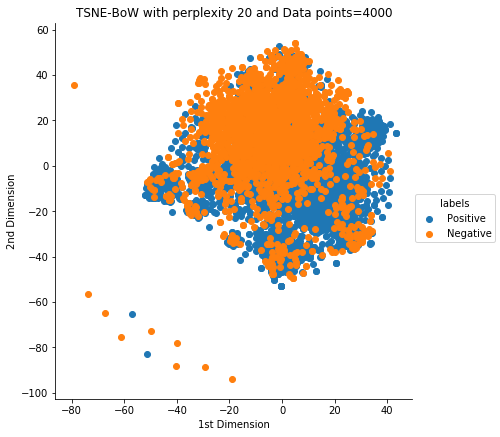

In [7]:
#visualizing the TSNE data 
tsne_df=pd.DataFrame(data=tnse_data,columns=('1st Dimension','2nd Dimension','labels'))
sns.FacetGrid(tsne_df,hue='labels',size=6).map(plt.scatter,'1st Dimension','2nd Dimension').add_legend()
plt.title('TSNE-BoW with perplexity 20 and Data points=4000')
plt.show()

### 2) Appliying TSNE with bi-gram,n-gram

In [3]:
count_vect_ngram=CountVectorizer(ngram_range=(1,2))
final_vect_ngram=count_vect_ngram.fit_transform(final_data['CleanedText'].values)
final_vect_ngram.shape

(4000, 130923)

In [4]:
final_vector_ngram=final_vect_ngram.toarray()
type(final_vector_ngram)

numpy.ndarray

In [5]:
model_ngram=TSNE(n_components=2,perplexity=20,random_state=0)
tsne_ngram=model_ngram.fit_transform(final_vector_ngram)
tsne_ngram=np.vstack((tsne_ngram.T,labels)).T

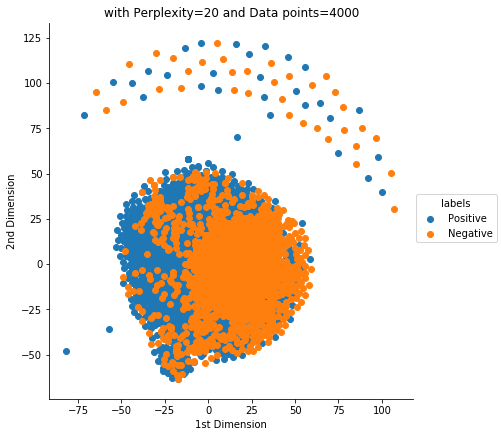

In [6]:
tsne_df=pd.DataFrame(data=tsne_ngram,columns=('1st Dimension','2nd Dimension','labels'))
sns.FacetGrid(tsne_df,hue='labels',size=6).map(plt.scatter,'1st Dimension','2nd Dimension').add_legend()
plt.title('with Perplexity=20 and Data points=4000')
plt.show()

 ### 3) Applying TSNE with TF-IDF

In [9]:
fit_vector=TfidfVectorizer(ngram_range=(1,2))
final_tfidf=fit_vector.fit_transform(final_data['CleanedText'].values)
final_tfidf.shape

(4000, 130923)

In [16]:

final_tfidf=final_tfidf.toarray()
type(final_tfidf)

numpy.ndarray

In [17]:
model_tfidf=TSNE(n_components=2,perplexity=30,random_state=0)
tsne_tfidf=model_tfidf.fit_transform(final_tfidf)
tsne_tfidf=np.vstack((tsne_tfidf.T,labels)).T

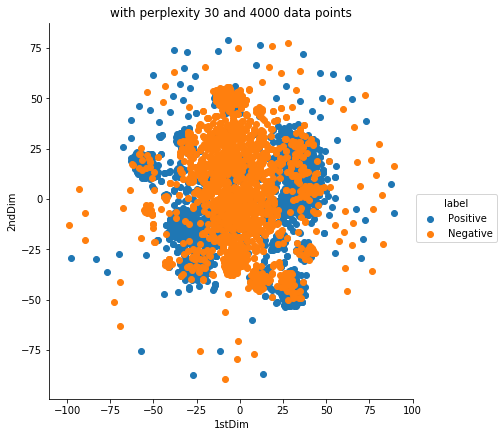

In [18]:
tsne_tfidf_viz=pd.DataFrame(data=tsne_tfidf,columns=('1stDim','2ndDim','label'))
sns.FacetGrid(tsne_tfidf_viz,hue='label',size=6).map(plt.scatter,'1stDim','2ndDim').add_legend()
plt.title("with perplexity 30 and 4000 data points")
plt.show()

### 4)  Word2Vec training on own text corpus

In [3]:
w2v_list=[]
for sent in (final_data['CleanedText'].values):
    w2v_list.append(sent.split())
print(w2v_list[0])

['product', 'archer', 'farm', 'best', 'drink', 'mix', 'ever', 'mix', 'flavor', 'packet', 'water', 'bottl', 'contain', 'natur', 'sweetner', 'stevia', 'real', 'fruit', 'flavor', 'food', 'color', 'color', 'fruit', 'veget', 'color', 'pure', 'natur', 'tast', 'great', 'eight', 'packet', 'box', 'contain', 'calori', 'per', 'packet', 'thank', 'archer', 'farm']


In [4]:
w2v_model=Word2Vec(w2v_list,size=50,min_count=5,workers=4)
w2v_words=list(w2v_model.wv.vocab)
print(len(w2v_words))

3269


In [5]:
w2v_model.wv.most_similar("good")

[('much', 0.9843345880508423),
 ('color', 0.9841805696487427),
 ('better', 0.9762856364250183),
 ('realli', 0.9754549264907837),
 ('qualiti', 0.9745361804962158),
 ('flavor', 0.9745179414749146),
 ('great', 0.9702613353729248),
 ('like', 0.9691296815872192),
 ('veri', 0.9664493799209595),
 ('too', 0.9597487449645996)]

Training went well :)

### 5) Average Word2Vec

In [6]:
sent_vect=[]
for sent in w2v_list:
    sent_vec=np.zeros(50)
    cnt_words=0
    for word in sent:
        if word in w2v_words:
            vec=w2v_model.wv[word]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words !=0:
        sent_vec/=cnt_words
    sent_vect.append(sent_vec)
    
print(len(sent_vect))
print(sent_vect[0])
        
    

4000
[ 0.48151772  0.45383447 -0.19104679 -0.03611794 -0.04695794  0.3265496
 -0.18133606 -0.57725439  0.41309421  0.54879844  0.2450787   0.31288971
  0.48983278 -0.3647506  -0.28034527 -0.19610504 -0.54447101  0.21531449
  0.13822659  0.21576535 -0.01518269 -0.21841766 -0.01219081  0.28673405
  0.22331528  0.25396575 -0.13447938  0.17789851 -0.10215905  0.01351546
 -0.41996837 -0.70723118 -0.45912833 -0.39457219  0.4288351   0.09876928
 -0.79073455  0.11179924 -0.20931848 -0.15258608  0.08103307 -0.75050943
 -0.10541571 -0.09804547 -0.28404543 -0.46848403  0.49400781  0.78893134
  0.11158306  0.15190185]


In [7]:
#sent_vect=sent_vect.toarray()

model_avgw2c=TSNE(n_components=2,perplexity=30,random_state=0)
tsne_avgw2c=model_avgw2c.fit_transform(sent_vect)
tsne_avgw2c=np.vstack((tsne_avgw2c.T,labels)).T

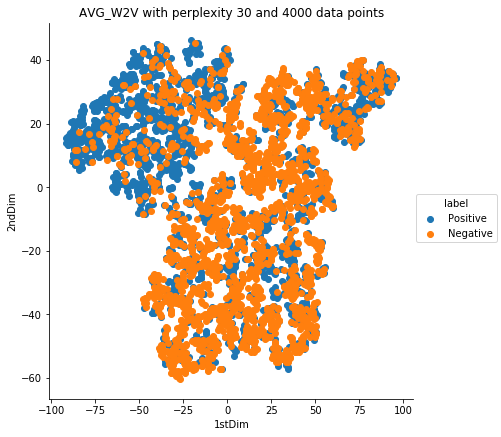

In [14]:
tsne_viz=pd.DataFrame(data=tsne_avgw2c,columns=('1stDim','2ndDim','label'))
sns.FacetGrid(tsne_viz,hue='label',size=6).map(plt.scatter,'1stDim','2ndDim').add_legend()
plt.title("AVG_W2V with perplexity 30 and 4000 data points")
plt.show()

### 6) TFIDF Weighted Word2Vec

In [10]:
features_tfidf=fit_vector.get_feature_names()
tfidf_sent_vect=[]

row=0
for sent in w2v_list:
    sent_vec=np.zeros(50)
    weight_sum=0
    for word in sent:
        if word in w2v_words:
            vec=w2v_model.wv[word]
            tf_idf=final_tfidf[row,features_tfidf.index(word)]
            sent_vec+=(vec*tf_idf)
            weight_sum+=tf_idf
            
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vect.append(sent_vec)
    row += 1


In [11]:
model_tf_w2v=TSNE(n_components=2,perplexity=30,random_state=0)
tsne_tf_w2v=model_tf_w2v.fit_transform(tfidf_sent_vect)
tsne_tf_w2v=np.vstack((tsne_tf_w2v.T,labels)).T

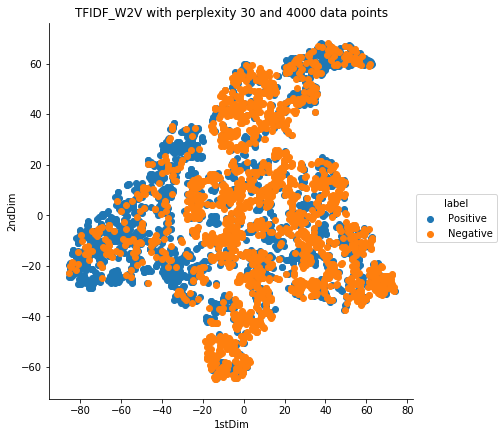

In [13]:
tsne_viz_tfidfw2v=pd.DataFrame(data=tsne_tf_w2v,columns=('1stDim','2ndDim','label'))
sns.FacetGrid(tsne_viz_tfidfw2v,hue='label',size=6).map(plt.scatter,'1stDim','2ndDim').add_legend()
plt.title("TFIDF_W2V with perplexity 30 and 4000 data points")
plt.show()

### Obervations<br>
1) With TFIDF and TFIDF weighted Word2Vec similar reviews are clustered nicely than other Vectorizing techinques<br>
2) Only 4k Reviews were taken because of hardware limitaions hence conclude on whole dataset<br>
3) T-SNE is just visualising tool to understand the data and we cannot draw any standard conclusion with this.<br>
4) Data preprocessing is an important step when we are proceeding towards model building<br>
